In [40]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 511.5 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.3/455.3 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 23.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 46.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Import

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool
import numpy as np
random_state = 42
np.random.seed(random_state)

In [2]:
df = pd.read_csv('data/train.csv')
df.columns = map(str.lower, df.columns.tolist())
df.sample(2)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S


# Feature engineering

In [3]:
name_sub_list = {
    'Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
    'Don', 'Jonkheer'
}
def name2title(row):
    kw = None
    for sub in name_sub_list:
        if sub.lower() in row['name'].lower():
            kw = sub
            break
    if kw is None:
        return np.nan
    if kw in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    if kw in ['Countess', 'Mme']:
        return 'Mrs'
    if kw in ['Mlle', 'Ms']:
        return 'Miss'
    if kw =='Dr':
        if row.sex =='Male':
            return 'Mr'
        else:
            return 'Mrs'
    return kw

def preproc(df):
    df['title'] = df.apply(name2title, axis=1)
    df['deck'] = df.cabin.apply(lambda x: 'hz' if x is np.nan else x[0])
    df['family_size'] = df.sibsp + df.parch
    df['fare_per_family'] = df.fare / df.family_size
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['age'] = df.age.fillna(df.age.mean()) # mean
    df['cabin'] = df.cabin.fillna('hz') # unknown
    df['embarked'] = df.embarked.fillna(df.embarked.value_counts().index[0]) # moda
    df['fare_per_family'] = df.fare_per_family.fillna(df.fare_per_family.mean()) # mean
    df.isna().sum()
    return df

In [4]:
df = preproc(df)

In [5]:
df.isna().sum()

passengerid        0
survived           0
pclass             0
name               0
sex                0
age                0
sibsp              0
parch              0
ticket             0
fare               0
cabin              0
embarked           0
title              0
deck               0
family_size        0
fare_per_family    0
dtype: int64

# Num cat cols split

In [6]:
target = 'survived'
cols_to_drop = ['passengerid', target]
num_cols = df.drop(columns=cols_to_drop).select_dtypes(include='number').columns.tolist()
cat_cols = df.drop(columns=cols_to_drop).select_dtypes(exclude='number').columns.tolist()
features_order = cat_cols + num_cols
print(f'{num_cols=}')
print(f'{cat_cols=}')
assert len(features_order) == len(set(features_order))

num_cols=['pclass', 'age', 'sibsp', 'parch', 'fare', 'family_size', 'fare_per_family']
cat_cols=['name', 'sex', 'ticket', 'cabin', 'embarked', 'title', 'deck']


In [7]:
df[num_cols].sample(3)

,pclass,age,sibsp,parch,fare,family_size,fare_per_family
384,3,29.699118,0,0,7.8958,0,31.85729
210,3,24.000000,0,0,7.0500,0,31.85729
486,1,35.000000,1,0,90.0000,1,90.00000


In [8]:
df[cat_cols].sample(3)

,name,sex,ticket,cabin,embarked,title,deck
254,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,370129,hz,S,Mrs,hz
884,"Sutehall, Mr. Henry Jr",male,SOTON/OQ 392076,hz,S,Mr,hz
777,"Emanuel, Miss. Virginia Ethel",female,364516,hz,S,Miss,hz


# Train test split 

In [9]:
X, y = df[features_order], df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 14), (179, 14), (712,), (179,))

# Preproc pipeline

In [10]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Model

In [11]:
%%time
cat_boost_clf = CatBoostClassifier(learning_rate=.0001, cat_features=cat_cols)
cat_boost_clf.fit(X_train, y_train, verbose=1)

0:	learn: 0.6930839	total: 58.8ms	remaining: 58.7s
1:	learn: 0.6930158	total: 61.3ms	remaining: 30.6s
2:	learn: 0.6929444	total: 63.6ms	remaining: 21.1s
3:	learn: 0.6928905	total: 65ms	remaining: 16.2s
4:	learn: 0.6928241	total: 67.1ms	remaining: 13.3s
5:	learn: 0.6927662	total: 70.3ms	remaining: 11.6s
6:	learn: 0.6927059	total: 72.3ms	remaining: 10.3s
7:	learn: 0.6926468	total: 74.6ms	remaining: 9.25s
8:	learn: 0.6926076	total: 75.3ms	remaining: 8.29s
9:	learn: 0.6925537	total: 77.2ms	remaining: 7.64s
10:	learn: 0.6924827	total: 80.7ms	remaining: 7.26s
11:	learn: 0.6924131	total: 83.5ms	remaining: 6.87s
12:	learn: 0.6923465	total: 85.1ms	remaining: 6.46s
13:	learn: 0.6922823	total: 87.9ms	remaining: 6.19s
14:	learn: 0.6922299	total: 89.7ms	remaining: 5.89s
15:	learn: 0.6921763	total: 90.6ms	remaining: 5.57s
16:	learn: 0.6921178	total: 92.4ms	remaining: 5.34s
17:	learn: 0.6920787	total: 92.9ms	remaining: 5.07s
18:	learn: 0.6920235	total: 94.2ms	remaining: 4.86s
19:	learn: 0.6919547	tot

# Validation

In [12]:
print(classification_report(y_test, cat_boost_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [13]:
%%time
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)
acc_ = list()
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    _clf = CatBoostClassifier(learning_rate=.0001, cat_features=cat_cols)
    _clf.fit(X_train, y_train, verbose=0)
    preds = _clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(acc)
    acc_.append(acc)
sum(acc_)/len(acc_)

0.8100558659217877
0.776536312849162
0.7877094972067039
0.8435754189944135
0.7821229050279329
CPU times: user 23.9 s, sys: 14.3 s, total: 38.1 s
Wall time: 8.47 s


0.8

# Submit

In [15]:
submit_test_proc

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,deck,family_size,fare_per_family
0,1,0,0.829568,"Braund, Mr. Owen Harris",male,-0.598709,0.478335,-0.466183,A/5 21171,-0.511601,hz,S,Mr,h,0.073412,-0.982283
1,2,1,-1.571457,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.631494,0.478335,-0.466183,PC 17599,0.821722,C85,C,Mrs,C,0.073412,1.589449
2,3,1,0.829568,"Heikkinen, Miss. Laina",female,-0.291158,-0.465084,-0.466183,STON/O2. 3101282,-0.497546,hz,S,Miss,h,-0.556339,0.006005
3,4,1,-1.571457,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.400831,0.478335,-0.466183,113803,0.443103,C123,S,Mrs,C,0.073412,0.859163
4,5,0,0.829568,"Allen, Mr. William Henry",male,0.400831,-0.465084,-0.466183,373450,-0.494943,hz,S,Mr,h,-0.556339,0.006005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,-0.370945,"Montvila, Rev. Juozas",male,-0.214270,-0.465084,-0.466183,211536,-0.391873,hz,S,Mr,h,-0.556339,0.006005
887,888,1,-1.571457,"Graham, Miss. Margaret Edith",female,-0.829372,-0.465084,-0.466183,112053,-0.037893,B42,S,Miss,B,-0.556339,0.006005
888,889,0,0.829568,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.006741,0.478335,1.921748,W./C. 6607,-0.174279,hz,S,Miss,h,1.332913,-0.959524
889,890,1,-1.571457,"Behr, Mr. Karl Howell",male,-0.291158,-0.465084,-0.466183,111369,-0.037893,C148,C,Mr,C,-0.556339,0.006005


In [22]:
submit_test = pd.read_csv('data/test.csv')
submit_test.columns = map(str.lower, submit_test.columns.tolist())
submit_test_proc = preproc(submit_test.copy())[features_order]
submit_test_proc[num_cols] = scaler.transform(submit_test_proc[num_cols])
submit_test[target] = cat_boost_clf.predict(submit_test_proc)
submit_test.sample(2)

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
391,1283,1,"Lines, Mrs. Ernest H (Elizabeth Lindsey James)",female,51.0,0,1,PC 17592,39.4,D28,S,1
172,1064,3,"Dyker, Mr. Adolf Fredrik",male,23.0,1,0,347072,13.9,NaN,S,0


In [24]:
submit_test.rename(columns={'PassengerId'.lower(): 'PassengerId', 'Survived'.lower(): 'Survived'})[['PassengerId', 'Survived']].to_csv('data/submit_feature_eng_catboost_clf.csv', index=False)
!du -hs 'data/submit_feature_eng_catboost_clf.csv'

4.0K	data/submit_feature_eng_catboost_clf.csv


# Feature importance

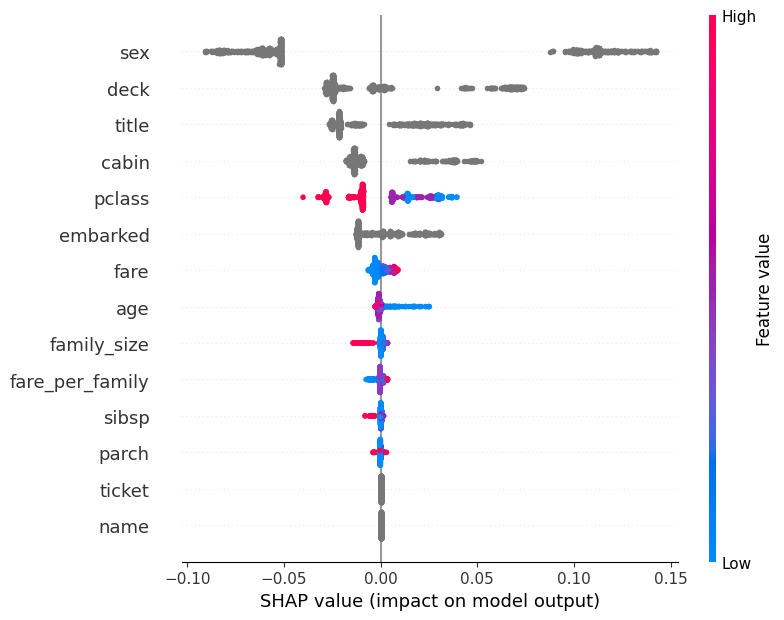

In [47]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(cat_boost_clf)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, max_display=20)